In [1]:
#Part 1: Data Preparation

In [2]:
import pandas as pd

In [3]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [4]:
# Convert date columns to datetime
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

In [5]:
# Handle missing values
customers.fillna({'gender': 'Unknown', 'location': 'Unknown'}, inplace=True)
transactions.fillna({'transaction_amount': 0, 'product_category': 'Unknown'}, inplace=True)
engagements.fillna(0, inplace=True)
marketing.fillna({'response': 'No', 'promotion_type': 'Unknown'}, inplace=True)

In [6]:
# Calculate customer tenure in days
customers['customer_tenure_days'] = (customers['last_purchase_date'] - customers['join_date']).dt.days


In [7]:
# Merge datasets on customer_id
merged_df = customers.merge(transactions, on='customer_id', how='left') \
                     .merge(engagements, on='customer_id', how='left') \
                     .merge(marketing, on='customer_id', how='left')


In [9]:
#Part 2: Exploratory Data Analysis (EDA)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# Descriptive statistics
print("Descriptive Statistics:")
print(merged_df.describe())

Descriptive Statistics:
         customer_id                      join_date  \
count  327251.000000                         327251   
mean     5003.032587  2022-03-20 05:15:22.136219648   
min         1.000000            2020-01-01 00:00:00   
25%      2513.000000            2021-02-16 00:00:00   
50%      5004.000000            2022-03-21 00:00:00   
75%      7461.000000            2023-04-30 00:00:00   
max     10000.000000            2024-05-31 00:00:00   
std      2878.441867                            NaN   

               last_purchase_date            age  customer_tenure_days  \
count                      327251  293971.000000         327251.000000   
mean   2023-04-23 21:34:28.412320      43.444972            399.679934   
min           2020-01-26 00:00:00      18.000000              0.000000   
25%           2022-09-17 00:00:00      30.000000            108.000000   
50%           2023-08-03 00:00:00      43.000000            300.000000   
75%           2024-02-10 00:00:00   

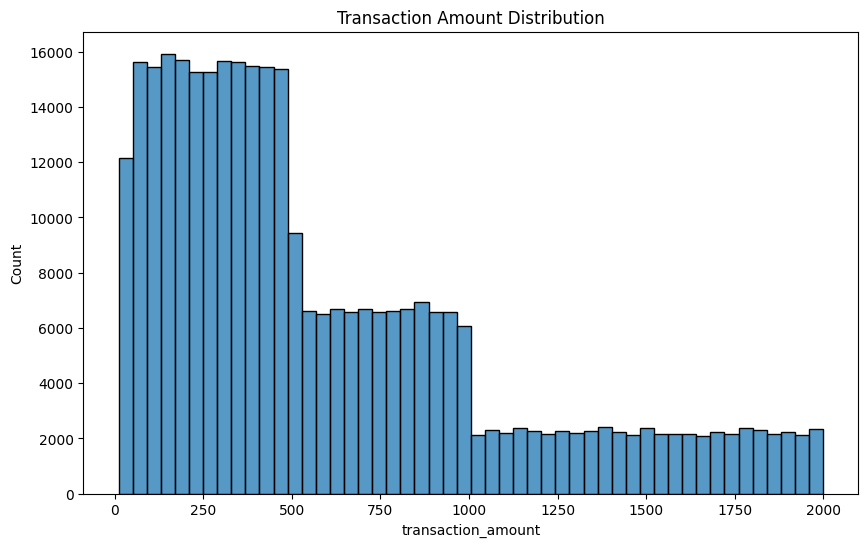

In [12]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['transaction_amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.show()

In [13]:
# Correlation matrix for numeric columns only
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])

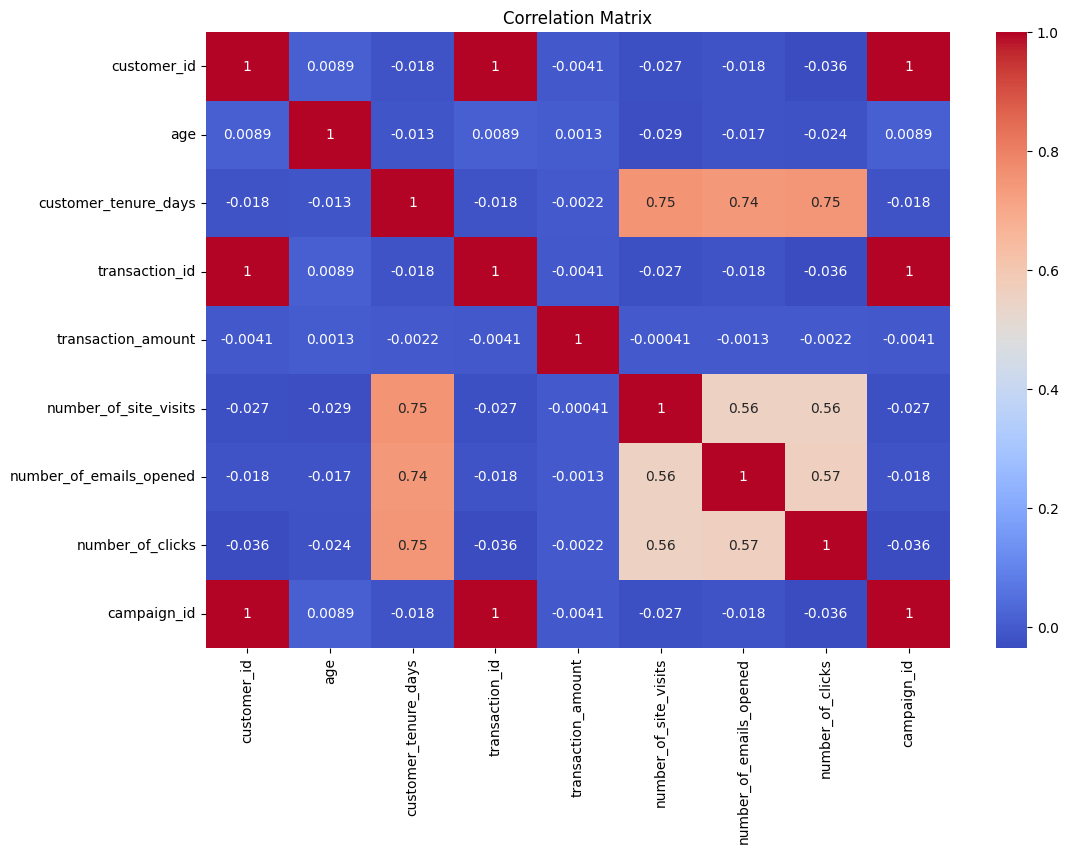

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [15]:
#Part 3: Feature Engineering

In [16]:
# Normalize monetary value by customer tenure
merged_df['normalized_monetary'] = merged_df.apply(
    lambda row: row['transaction_amount'] / row['customer_tenure_days'] if row['customer_tenure_days'] > 0 else 0, axis=1)


In [17]:
# Early behavior indicators
early_period = 30  # first 30 days
merged_df['early_total_spent'] = merged_df.apply(
    lambda row: row['transaction_amount'] if (row['transaction_date'] - row['join_date']).days <= early_period else 0, axis=1)
merged_df['early_frequency'] = merged_df.apply(
    lambda row: 1 if (row['transaction_date'] - row['join_date']).days <= early_period else 0, axis=1)
merged_df['early_recency'] = merged_df.apply(
    lambda row: (early_period - (row['transaction_date'] - row['join_date']).days) if (row['transaction_date'] - row['join_date']).days <= early_period else 0, axis=1)


In [18]:
# Aggregating engagement metrics
engagement_metrics = engagements.groupby('customer_id').agg({
    'number_of_site_visits': 'sum',
    'number_of_emails_opened': 'sum',
    'number_of_clicks': 'sum'
}).reset_index()

In [19]:
# Aggregating early behavior metrics
early_metrics = merged_df.groupby('customer_id').agg({
    'early_total_spent': 'sum',
    'early_frequency': 'sum',
    'early_recency': 'max',
    'normalized_monetary': 'sum'
}).reset_index()

In [20]:
# Merge early behavior and engagement metrics
final_df = customers.merge(early_metrics, on='customer_id', how='left') \
                    .merge(engagement_metrics, on='customer_id', how='left')

print("Final DataFrame for Modeling:")
print(final_df.head())

Final DataFrame for Modeling:
   customer_id  join_date last_purchase_date   age   gender  \
0            1 2023-11-20         2024-03-17  56.0   Female   
1            2 2021-09-08         2023-10-25   NaN     Male   
2            3 2021-06-01         2022-11-27   NaN  Unknown   
3            4 2022-01-01         2022-09-01  29.0     Male   
4            5 2022-01-24         2023-06-02   NaN     Male   

            location  customer_tenure_days  early_total_spent  \
0  North Shannonbury                   118               0.00   
1          Hillville                   777            7466.24   
2   North Latoyatown                   544               0.00   
3          Grossstad                   243             618.52   
4   East Matthewfort                   494               0.00   

   early_frequency  early_recency  normalized_monetary  number_of_site_visits  \
0                0              0           118.965424                     10   
1                4              9     

In [21]:
#Part 4: Calculating Specific Insights

In [38]:
# Insights calculations
high_early_spenders = final_df[final_df['early_total_spent'] > 200]
low_early_spenders = final_df[final_df['early_total_spent'] < 50]

high_early_spender_clv = high_early_spenders['normalized_monetary'].mean() * high_early_spenders['customer_tenure_days'].mean()
low_early_spender_clv = low_early_spenders['normalized_monetary'].mean() * low_early_spenders['customer_tenure_days'].mean()

high_freq_customers = final_df[final_df['early_frequency'] > 5]
low_freq_customers = final_df[final_df['early_frequency'] < 2]

high_freq_clv = high_freq_customers['normalized_monetary'].mean() * high_freq_customers['customer_tenure_days'].mean()
low_freq_clv = low_freq_customers['normalized_monetary'].mean() * low_freq_customers['customer_tenure_days'].mean()

high_site_visits = final_df[final_df['number_of_site_visits'] > 10]
low_site_visits = final_df[final_df['number_of_site_visits'] < 3]

high_site_visits_clv = high_site_visits['normalized_monetary'].mean() * high_site_visits['customer_tenure_days'].mean()
low_site_visits_clv = low_site_visits['normalized_monetary'].mean() * low_site_visits['customer_tenure_days'].mean()

high_email_openers = final_df[final_df['number_of_emails_opened'] > 5]
low_email_openers = final_df[final_df['number_of_emails_opened'] == 0]

high_email_openers_clv = high_email_openers['normalized_monetary'].mean() * high_email_openers['customer_tenure_days'].mean()
low_email_openers_clv = low_email_openers['normalized_monetary'].mean() * low_email_openers['customer_tenure_days'].mean()

print(f"High Early Spenders CLV: ${high_early_spender_clv:.2f}")
print(f"Low Early Spenders CLV: ${low_early_spender_clv:.2f}")
print(f"High Frequency Customers CLV: ${high_freq_clv:.2f}")
print(f"Low Frequency Customers CLV: ${low_freq_clv:.2f}")
print(f"High Site Visits CLV: ${high_site_visits_clv:.2f}")
print(f"Low Site Visits CLV: ${low_site_visits_clv:.2f}")
print(f"High Email Openers CLV: ${high_email_openers_clv:.2f}")
print(f"Low Email Openers CLV: ${low_email_openers_clv:.2f}")

High Early Spenders CLV: $140644.97
Low Early Spenders CLV: $18106.69
High Frequency Customers CLV: $133000.65
Low Frequency Customers CLV: $16858.11
High Site Visits CLV: $43089.23
Low Site Visits CLV: $168847.89
High Email Openers CLV: $39445.39
Low Email Openers CLV: $nan


In [25]:
#Part 5: Model Training, Cross-Validation, and Hyperparameter Tuning

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer

In [27]:
# Prepare data for modeling
features = ['early_total_spent', 'early_frequency', 'early_recency',
            'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 'age']
X = final_df[features]
y = final_df['normalized_monetary']

In [28]:
# Handle missing values by imputing with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [30]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor()
}

In [31]:
# Define hyperparameters for grid search
param_grid = {
    'KNN': {'n_neighbors': [3, 5, 7, 9]}
}

In [32]:
# Define custom scoring function
scoring = {'MAE': make_scorer(mean_absolute_error), 'RMSE': make_scorer(mean_squared_error, squared=False)}



In [33]:
results = {}
best_estimators = {}

In [34]:
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=scoring, refit='RMSE')
        grid_search.fit(X_train, y_train)
        best_estimators[name] = grid_search.best_estimator_
        y_pred = grid_search.best_estimator_.predict(X_test)
        results[name] = {
            'Best Params': grid_search.best_params_,
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False)
        }
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = {
            'Cross-Val MAE': -cv_scores.mean(),
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False)
        }

In [35]:
results_df = pd.DataFrame(results).T
print("Model Performance:")
print(results_df)

Model Performance:
                  Cross-Val MAE         MAE         RMSE         Best Params
Linear Regression    365.497687  349.161627  1300.425741                 NaN
KNN                         NaN  338.499158  1668.070414  {'n_neighbors': 3}


In [36]:
#Part 6: Business Impact Analysis

In [37]:
# Example code for calculating potential revenue increase
high_value_customers = final_df[final_df['normalized_monetary'] > final_df['normalized_monetary'].quantile(0.75)]
potential_revenue_increase = high_value_customers['normalized_monetary'].sum() * 0.05  # Assuming a 5% increase in retention

print(f"Potential Revenue Increase: ${potential_revenue_increase:.2f}")

Potential Revenue Increase: $154402.18
